In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (10, 5)


# Lecture 09 - Imputation

## DSC 80, Fall 2022

## Today, in DSC 80...

- We know *how* data can go missing.
- How do we *replace* missing values intelligently?

## Review: Missingness mechanisms

### Review: Missingness mechanisms

- **Missing by design (MD):** Whether or not a value is missing depends entirely on the data in other columns. In other words, if we can always predict if a value will be missing given the other columns, the data is MD.
- **Not missing at random (NMAR, also called NI):** The chance that a value is missing **depends on the actual missing value**!
- **Missing at random (MAR):** The chance that a value is missing **depends on other columns**, but **not** the actual missing value itself.
- **Missing completely at random (MCAR):** The chance that a value is missing is **completely independent** of other columns and the actual missing value.

### Deciding between MAR and MCAR

- Recall, the "missing value flowchart" says that we should:
    - First, determine whether values are **missing by design (MD)**.
    - Then, reason about whether values are **not missing at random (NMAR)**.
    - Finally, decide whether values are **missing at random (MAR)** or **missing completely at random (MCAR)**.
- To decide between MAR and MCAR, we can look at the data itself.

In [3]:
heights = pd.read_csv(os.path.join('data', 'heights.csv'))
heights = (
    heights
    .rename(columns={'childHeight': 'child', 'childNum': 'number'})
    .drop('midparentHeight', axis=1)
)
heights.head()

,family,father,mother,children,number,gender,child
0,1,78.5,67.0,4,1,male,73.2
1,1,78.5,67.0,4,2,female,69.2
2,1,78.5,67.0,4,3,female,69.0
3,1,78.5,67.0,4,4,female,69.0
4,2,75.5,66.5,4,1,male,73.5


### Example: Missingness of `'child'` heights on `'father'`'s heights (MCAR)

- **Question:** Is the missingness of `'child'` heights dependent on the `'father'` column?
- To answer, we can look at two distributions:
    - The distribution of `'father'` when `'child'` is missing.
    - The distribution of `'father'` when `'child'` is not missing.
- If the two distributions look similar, then the missingness of `'child'` is not dependent on `'father'`.
    - To test whether two distributions look similar, we use a permutation test.

- In `util.py`, there are several functions that we've created to help us with this lecture. 
    - `make_mcar` takes in a dataset and intentionally drops values from a column such that they are MCAR. 
    - You wouldn't actually do this in practice!

In [4]:
# Generating MCAR data
heights_mcar = util.make_mcar(heights, 'child', pct=0.5)
heights_mcar.isna().mean()

family      0.0
father      0.0
mother      0.0
children    0.0
number      0.0
gender      0.0
child       0.5
dtype: float64

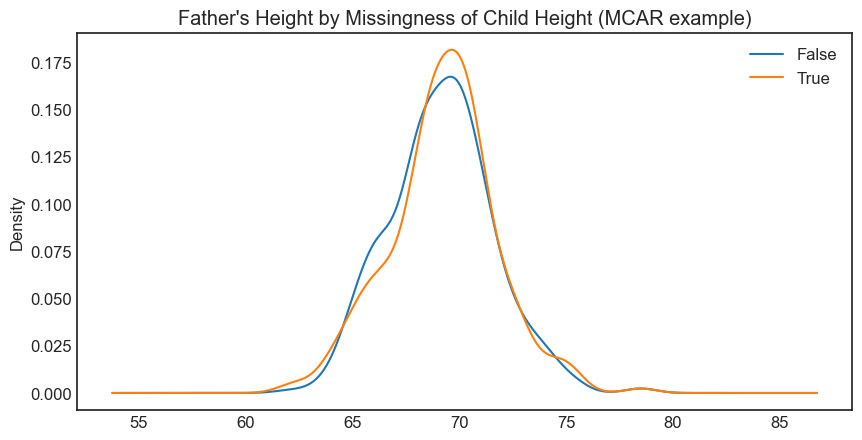

In [5]:
heights_mcar['child_missing'] = heights_mcar['child'].isna()

(
    heights_mcar
    .groupby('child_missing')['father']
    .plot(kind='kde', legend=True, title="Father's Height by Missingness of Child Height (MCAR example)")
);

- To test whether the two distributions are similar, we can use a permutation test. 
- The `ks_2samp` function from `scipy.stats` can do the entire permutation test for us, if we want to use the Kolmogorov-Smirnov test statistic!
    - If we want to use the difference of means, we'd have to run a `for`-loop (see Lecture 10 and 12 for examples).

In [6]:
# 'father' when 'child' is missing 
father_ch_mis = heights_mcar.loc[heights_mcar['child_missing'], 'father']

# 'father' when 'child' is not missing
father_ch_not_mis = heights_mcar.loc[~heights_mcar['child_missing'], 'father']

In [7]:
stats.ks_2samp(father_ch_mis, father_ch_not_mis)

KstestResult(statistic=0.055674518201284794, pvalue=0.4645992385588452)

- This states that if the missingness of `'child'` is truly unrelated to the distribution of `'father'`, then the chance of seeing two distributions that are as or more different than our two observed `'father'` distributions is 83%.
- We fail to reject the null – it looks like the missingness of `'child'` is likely unrelated to the distribution of `'father'`.

### Discussion Question

In this MCAR example, if we were to take the mean of the `'child'` column that contains missing values, is the result likely to:

1. Overestimate the true mean?
2. Underestimate the true mean?
3. Be accurate?

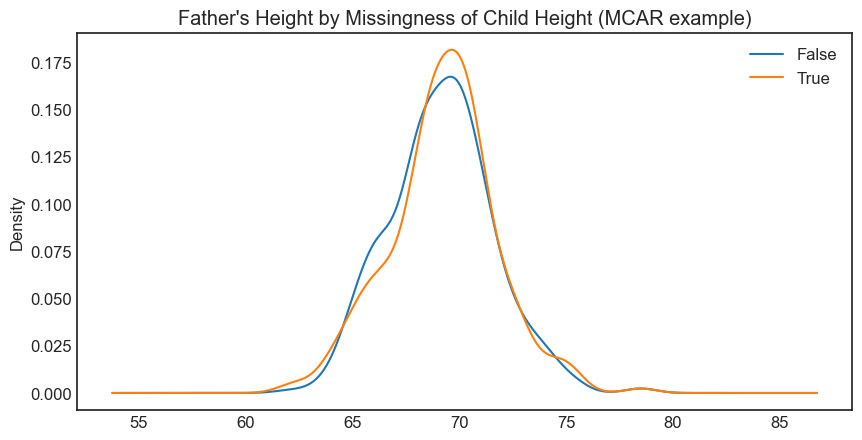

In [8]:
(
    heights_mcar
    .groupby('child_missing')['father']
    .plot(kind='kde', legend=True, title="Father's Height by Missingness of Child Height (MCAR example)")
);

### Example: Missingness of `'child'` heights on `'father'`'s heights (MAR)

- **Question:** Is the missingness of `'child'` heights dependent on the `'father'` column?
- We will follow the same procedure as before. The only difference is that the missing values in our simulated data are MAR.

In [9]:
# Generating MAR data
heights_mar = util.make_mar_on_num(heights, 'child', 'father', pct=0.75)
heights_mar.isna().mean()

family      0.000000
father      0.000000
mother      0.000000
children    0.000000
number      0.000000
gender      0.000000
child       0.749465
dtype: float64

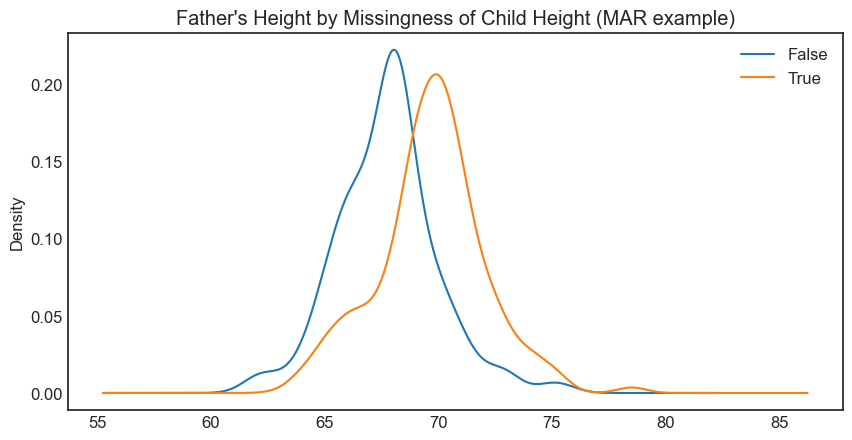

In [10]:
heights_mar['child_missing'] = heights_mar['child'].isna()

(
    heights_mar
    .groupby('child_missing')['father']
    .plot(kind='kde', legend=True, title="Father's Height by Missingness of Child Height (MAR example)")
);

- The above picture shows us that missing `'child'` heights tend to come from taller `'father'`s heights.
- Let's again use a permutation test.

In [11]:
# 'father' when 'child' is missing 
father_ch_mis = heights_mar.loc[heights_mar['child_missing'], 'father']

# 'father' when 'child' is not missing
father_ch_not_mis = heights_mar.loc[~heights_mar['child_missing'], 'father']

In [12]:
stats.ks_2samp(father_ch_mis, father_ch_not_mis)

KstestResult(statistic=0.48356532356532356, pvalue=5.551115123125783e-16)

- The p-value of our permutation test is essentially 0.
- We reject the null that the missingness of the `'child'` column is independent of the `'father'` column, and we conclude that `'child'` is MAR dependent on `'father'`.

### Discussion Question

In this MAR example, if we were to take the mean of the `'child'` column that contains missing values, is the result likely to:

1. Overestimate the true mean?
2. Underestimate the true mean?
3. Be accurate?

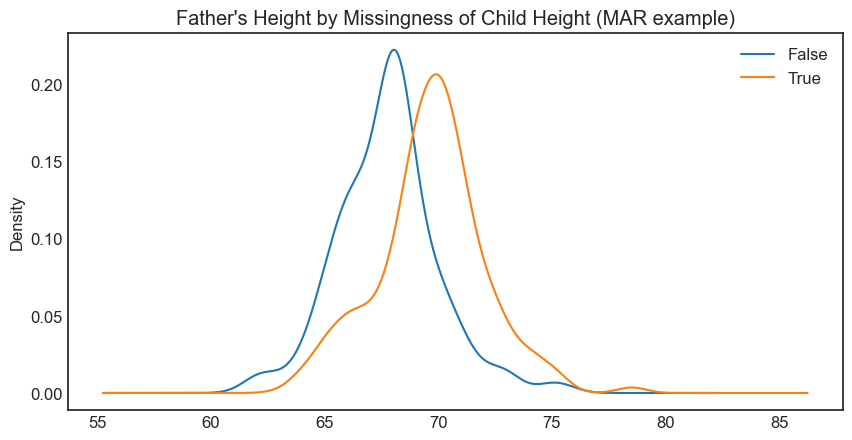

In [13]:
(
    heights_mar
    .groupby('child_missing')['father']
    .plot(kind='kde', legend=True, title="Father's Height by Missingness of Child Height (MAR example)")
);

## Handling missing values

### What do we do with missing data?

- Suppose we are interested in a dataset $Y$. 
- We get to **observe** $Y_{obs}$, while the rest of the dataset, $Y_{mis}$, is **missing**.
- Issue: $Y_{obs}$ may look quite different than $Y$.
    - The mean and other measures of central tendency may be different.
    - The variance may be different.
    - Correlations between variables may be different.

### Example: Charity

- Consider a survey with an optional question: "How much do you give to charity?"
- People who give little are less likely to respond.
- Therefore, the average response is **biased high**.

### Solution 1: Dropping missing values

- If the data are MCAR (missing completely at random), then dropping the missing values entirely doesn't significantly change the data.
    - For instance, the mean of the dataset post-dropping is an unbiased estimate of the true mean.
    - This is because MCAR data is a **random sample** of the full dataset.
    - From DSC 10, we know that random samples tend to resemble the larger populations they are drawn from.
- **If the data are not MCAR, then dropping the missing values will introduce bias.**
    - MCAR is rare!

### Listwise deletion

- _Listwise deletion_ is the act of dropping entire rows that contain missing values.
- Issue: This can delete perfectly good data in other columns for a given row.
    - Improvement: Drop missing data only when working with the column that contains missing data.

To illustrate, let's generate another dataset with missing values.

In [14]:
np.random.seed(42) # So that we get the same results each time (for lecture)
heights_mcar = util.make_mcar(heights, 'child', pct=0.50)
heights_mar = util.make_mar_on_cat(heights, 'child', 'gender', pct=0.50)

The true `'child'` mean with all of the data is as follows.

In [15]:
heights['child'].mean()

66.74593147751597

The `'child'` mean in the MCAR dataset is very close to the true `'child'` mean:

In [16]:
heights_mcar['child'].dropna().mean()

66.64068522483944

In [17]:
# Note that .mean() automatically drops nulls, so this expression is the same as the one above
heights_mcar['child'].mean()

66.64068522483944

The `'child'` mean in the MAR dataset is quite biased. Note that this is not the same example as before.

In [18]:
heights_mar['child'].mean()

68.51884368308356

### Solution 2: Imputation

**Imputation** is the act of filling in missing data with plausable values. Ideally, imputation:

* is quick and easy to do.
* shouldn't introduce bias into the dataset.

These are hard to satisfy!

### Kinds of imputation

- There are three main types of imputation, two of which we will focus on today:

    - **Imputation with a single value: mean, median, mode.**
    - Imputation with a single value, using a model: regression, kNN.
    - **Probabilistic imputation by drawing from a distribution.**

- Each has upsides and downsides, and **each works differently with different types of missingness**.

## Mean imputation

### Mean imputation

- Mean imputation is the act of filling in missing values in a column with the mean of the observed values in that column.
- This strategy:
    - 👍 Preserves the mean of the observed data, for all types of missingness.
    - 👎 Decreases the variance of the data, for all types of missingness.
    - 👎 Creates a biased estimate of the true mean when the data are not MCAR.

### Example: Mean imputation in the MCAR `heights` dataset

Let's look at two distributions:
- The distribution of **all `'child'` heights**.
- The distribution of the **`'child'` heights that have MCAR values**.

In [19]:
heights_mcar['child'].head()

0    73.2
1    69.2
2     NaN
3     NaN
4    73.5
Name: child, dtype: float64

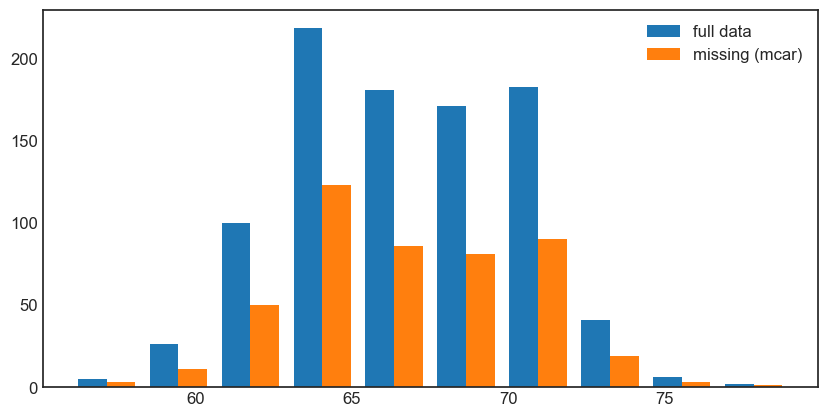

In [20]:
# Note that this is **not** a density histogram!
plt.hist([heights['child'], heights_mcar['child'].dropna()])
plt.legend(['full data', 'missing (mcar)']);

- Since the data is MCAR, the blue distribution has the same shape as the orange distribution.
- Let's fill in missing values with the mean of the observed `'child'` heights.

In [21]:
heights_mcar['child'].head()

0    73.2
1    69.2
2     NaN
3     NaN
4    73.5
Name: child, dtype: float64

In [22]:
heights_mcar_mfilled = heights_mcar.fillna(heights_mcar['child'].mean())
heights_mcar_mfilled['child'].head()

0    73.200000
1    69.200000
2    66.640685
3    66.640685
4    73.500000
Name: child, dtype: float64

- Note that the mean of the full set of heights is very close to the mean of the subset of heights that weren't missing.
- Also note that the mean of the imputed dataset is the same as the mean of the subset of heights that weren't missing.

In [23]:
print(
    'mean (original): %f' % heights['child'].mean(),
    'mean (missing):  %f' % heights_mcar['child'].mean(),
    'mean (mean imp): %f' % heights_mcar_mfilled['child'].mean(),
    sep='\n'
)

mean (original): 66.745931
mean (missing):  66.640685
mean (mean imp): 66.640685


- Why is the standard deviation of the imputed dataset smaller than either of the other two?

In [24]:
print(
    'std (original): %f' % heights['child'].std(),
    'std (missing):  %f' % heights_mcar['child'].std(),
    'std (mean imp): %f' % heights_mcar_mfilled['child'].std(),
    sep='\n'
)

std (original): 3.579251
std (missing):  3.563299
std (mean imp): 2.518282


### Mean imputation of MCAR data

Let's take a look at all three distributions: the original, the MCAR heights with missing values, and the imputed MCAR heights.

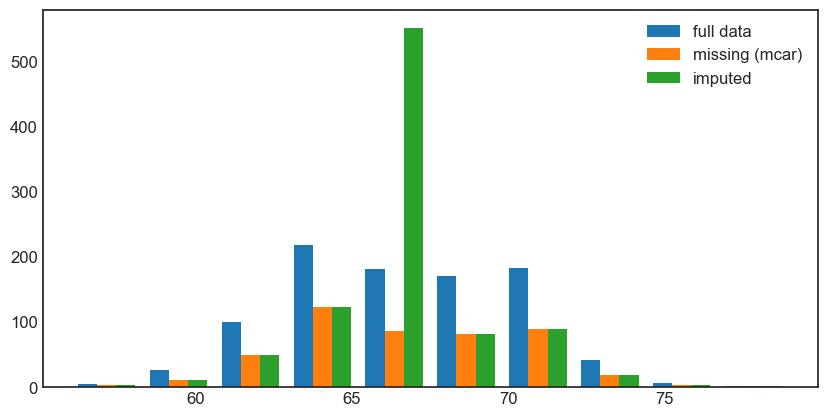

In [25]:
plt.hist([heights['child'], heights_mcar['child'].dropna(), heights_mcar_mfilled['child']])
plt.legend(['full data', 'missing (mcar)', 'imputed']);

**Takeaway:** When data are MCAR and you impute with the mean:
- The mean of the imputed dataset is an unbiased estimator of the true mean.
- The variance of the imputed dataset is smaller than the variance of the full dataset.
    - Mean imputation tricks you into thinking your data are more reliable than they are!

### Example: Mean imputation in the MAR `heights` dataset

- When data are MAR, mean imputation leads to biased estimates of the mean across groups.
- The bias may be different in different groups.
    - For example: If the missingness depends on gender, then different genders will have differently-biased means.
    - The overall mean will be biased towards one group.

In [26]:
np.random.seed(42) # So that we get the same results each time (for lecture)
heights_mar_cat = util.make_mar_on_cat(heights, 'child', 'gender', pct=0.50)
heights_mar_cat['child'].head()

0     NaN
1    69.2
2    69.0
3    69.0
4     NaN
Name: child, dtype: float64

Again, let's look at two distributions:
- The distribution of **all `'child'` heights**.
- The distribution of the **`'child'` heights that have MAR values**.

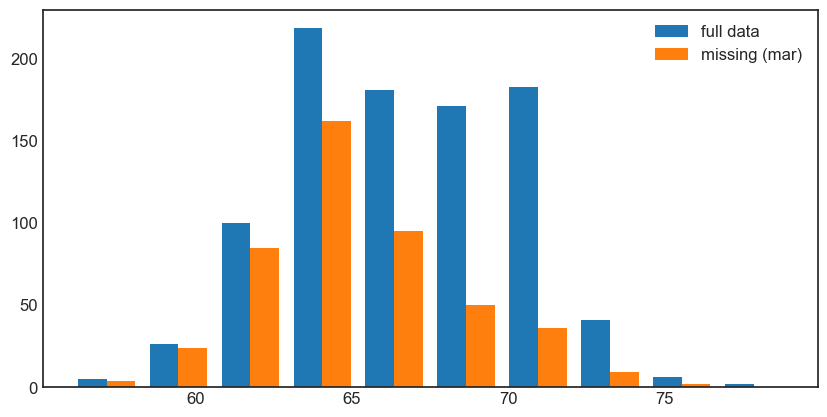

In [27]:
# The observed vs true distribution
plt.hist([heights['child'], heights_mar_cat['child']])
plt.legend(['full data', 'missing (mar)']);

- Let's impute with the mean.

In [28]:
heights_mar_cat_mfilled = heights_mar_cat.fillna(heights_mar_cat['child'].mean())
heights_mar_cat_mfilled

,family,father,mother,children,number,gender,child
0,1,78.5,67.0,4,1,male,64.999358
1,1,78.5,67.0,4,2,female,69.200000
2,1,78.5,67.0,4,3,female,69.000000
3,1,78.5,67.0,4,4,female,69.000000
4,2,75.5,66.5,4,1,male,64.999358
...,...,...,...,...,...,...,...
929,203,62.0,66.0,3,1,male,64.999358
930,203,62.0,66.0,3,2,female,62.000000
931,203,62.0,66.0,3,3,female,64.999358
932,204,62.5,63.0,2,1,male,64.999358


- Note that the latter two means are biased **low**.

In [29]:
print(
    'mean (original): %f' % heights['child'].mean(),
    'mean (missing):  %f' % heights_mar_cat['child'].mean(),
    'mean (mean imp): %f' % heights_mar_cat_mfilled['child'].mean(),
    sep='\n'
)

mean (original): 66.745931
mean (missing):  64.999358
mean (mean imp): 64.999358


In [30]:
print(
    'std (original): %f' % heights.child.std(),
    'std (missing):  %f' % heights_mar_cat.child.std(),
    'std (mean imp): %f' % heights_mar_cat_mfilled.child.std(),
    sep='\n'
)

std (original): 3.579251
std (missing):  3.166655
std (mean imp): 2.237963


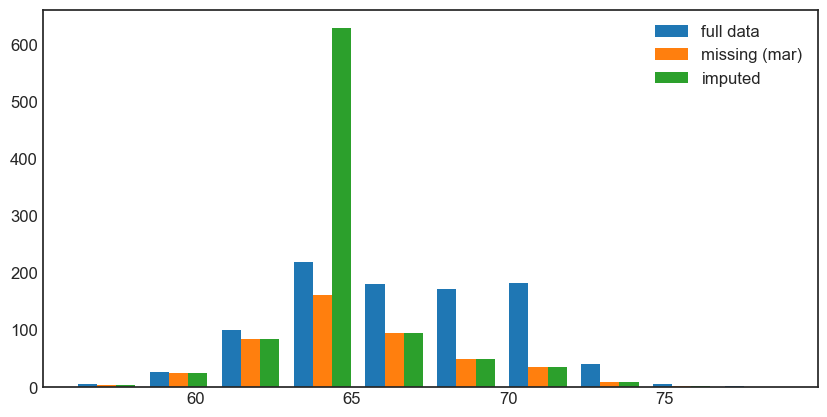

In [31]:
plt.hist([heights['child'], heights_mar_cat['child'], heights_mar_cat_mfilled['child']]);
plt.legend(['full data', 'missing (mar)', 'imputed']);

- Since the sample with MAR values was already biased low, mean imputation kept the sample biased – it did not bring the data **closer to the data generating process**.

### Within-group (conditional) mean imputation


* **Improvement:** Since MAR data are MCAR within each group, we can perform group-wise mean imputation.
    - In our case, since the missingness of `'child'` is dependent on `'gender'`, we can impute separately for each `'gender'`.
    - For instance, if there is a missing `'child'` height for a `'female'` child, impute their height with the mean observed `'female'` height.
- With this technique, the overall mean remains unbiased, as do the within-group means.
- Like single mean imputation, the variance of the dataset is reduced.

In [32]:
pd.concat([
    heights.groupby('gender')['child'].mean().rename('full'),
    heights_mar_cat.groupby('gender')['child'].mean().rename('missing (mar)'),
    heights_mar_cat_mfilled.groupby('gender')['child'].mean().rename('naively imputed')
], axis=1)

,full,missing (mar),naively imputed
gender,,,
female,64.103974,64.011024,64.168110
male,69.234096,69.377907,65.782217


Note that with our single mean imputation strategy, the resulting male mean height is biased quite low.

### Discussion Question

- In MAR data, imputation by the overall mean gives a biased estimate of the mean of each group. 
- To obtain an unbiased estimate of the mean within each group, impute using the mean within each group.
- How do we implement this?
    - Remember, our setting is that `'child'` heights are MAR dependent on `'gender'`.
    - Remember that unconditional mean imputation is implemented with `heights['child'].fillna(heights['child'].mean())`.

In [33]:
def mean_impute(ser):
    return ser.fillna(ser.mean())

heights_mar_cat.groupby('gender')['child'].transform(mean_impute)

0      69.377907
1      69.200000
2      69.000000
3      69.000000
4      69.377907
         ...    
929    69.377907
930    62.000000
931    64.011024
932    69.377907
933    57.000000
Name: child, Length: 934, dtype: float64

### Conclusion: Imputation with single values
* Imputing missing data in a column with the mean of the column:
    - faithfully reproduces the mean of the observed dataset,
    - reduces the variance, and
    - biases relationships between the column and other columns if the data are not MCAR.
    
* The same is true with other statistics (e.g. median and mode).

### Discussion Question

* The US Census asks individuals for their salaries, and some individuals don't respond. 
* Suppose we impute missing salaries with the mean overall salary.
* Is there more bias in:
    - (low-paying) service jobs or 
    - (high-paying) executive jobs?
    
***Hint:*** What does the distribution of incomes look like? Where is the mean/median?

## Probabilistic imputation

### Imputing missing values using distributions
- So far, each missing value in a column has been filled in with a constant value.
    - This creates "spikes" in the imputed distributions.
- **Idea:**We can **probabilistically** impute missing data from a distribution.
    - We can fill in missing data by drawing from the distribution of the ***non-missing** data.
    - There are 5 missing values? Pick 5 values from the data that aren't missing.
     - How? Using `.sample`.

### Example: Probabilistic imputation in the MCAR `heights` dataset

Steps:
1. Figure out the number of missing values.
2. Sample that number of values from the observed dataset.
3. Fill in the missing values with the sample from Step 2.

Step 1: Figure out the number of missing values.

In [34]:
num_null = heights_mcar['child'].isna().sum()
num_null

467

Step 2: Sample that number of values from the observed dataset.

In [35]:
fill_values = heights_mcar.child.dropna().sample(num_null, replace=True)
fill_values

253    73.0
640    66.0
50     70.5
288    67.0
27     64.0
       ... 
655    73.5
855    61.0
930    62.0
16     69.0
691    64.0
Name: child, Length: 467, dtype: float64

Step 3: Fill in the missing values with the sample from Step 2.

In [36]:
# Find the positions where values in heights_mcar are missing
fill_values.index = heights_mcar.loc[heights_mcar['child'].isna()].index

# Fill in the missing values
heights_mcar_dfilled = heights_mcar.fillna({'child': fill_values.to_dict()})  # fill the vals

Let's look at the results.

In [37]:
print(
    'mean (original):  %f' % heights['child'].mean(),
    'mean (missing):   %f' % heights_mcar['child'].mean(),
    'mean (distr imp): %f' % heights_mcar_dfilled['child'].mean(),
    sep='\n'
)

mean (original):  66.745931
mean (missing):   66.640685
mean (distr imp): 66.659529


In [38]:
print(
    'std (original):  %f' % heights['child'].std(),
    'std (missing):   %f' % heights_mcar['child'].std(),
    'std (distr imp): %f' % heights_mcar_dfilled['child'].std(),
    sep='\n'
)

std (original):  3.579251
std (missing):   3.563299
std (distr imp): 3.501084


Variance is preserved!

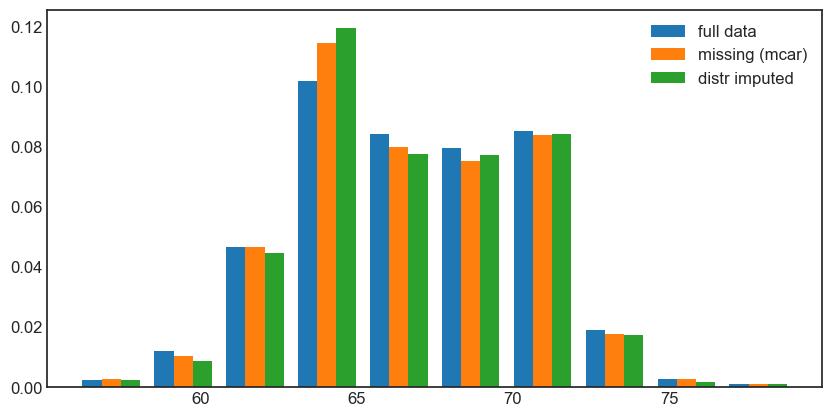

In [39]:
plt.hist([heights['child'], heights_mcar['child'], heights_mcar_dfilled['child']], density=True);
plt.legend(['full data','missing (mcar)', 'distr imputed']);

No spikes!

### Observations

- With this technique, the missing values were filled in with observed values in the dataset.
- If a value was never observed in the dataset, it will never be used to fill in a missing value.
    - For instance, if the observed heights were 68, 69, and 69.5 inches, we will never fill a missing value with 68.5 inches even though it's a perfectly reasonable height.
    
- Solution? Create a histogram (with `np.histogram`) to bin the data, then sample from the histogram.
    - See Lab 5, Question 4.

- **Question:** How would we generalize this process for MAR data?

### Randomness

- Unlike mean imputation, probabilistic imputation is **random** – each time you run the cell in which imputation is performed, the results could be different.
- **Multiple imputation**: Generate multiple imputed datasets and aggregate the results!
    - Similar to bootstrapping.

### Multiple imputation

Steps:

0. Start with observed and incomplete data. 
1. Create several **imputed** versions of the data through a probabilistic procedure.
    - The imputed datasets are identical for the observed data entries.
    - They differ in the imputed values. 
    - The differences reflect our **uncertainty** about what value to impute.

2. Then, estimate the parameters of interest for **each** imputed dataset.
    - For instance, the mean, standard deviation, median, etc.
3. Finally, pool the m parameter estimates into one estimate.

Let's try this procedure out on the `heights_mcar` dataset.

In [40]:
heights_mcar.head()

,family,father,mother,children,number,gender,child
0,1,78.5,67.0,4,1,male,73.2
1,1,78.5,67.0,4,2,female,69.2
2,1,78.5,67.0,4,3,female,NaN
3,1,78.5,67.0,4,4,female,NaN
4,2,75.5,66.5,4,1,male,73.5


In [41]:
# This function implements the 3-step process we studied earlier
def create_imputed(col):
    num_null = col.isna().sum()
    fill_values = col.dropna().sample(num_null, replace=True)
    fill_values.index = col.loc[col.isna()].index
    return col.fillna(fill_values.to_dict())

Each time we run the following cell, it generates a new imputed version of the `'child'` column.

In [42]:
create_imputed(heights_mcar['child']).head()

0    73.2
1    69.2
2    62.0
3    65.0
4    73.5
Name: child, dtype: float64

Let's run the above procedure 100 times.

In [43]:
mult_imp = pd.concat([create_imputed(heights_mcar['child']).rename(k) for k in range(100)], axis=1)
mult_imp.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,73.2,73.2,73.2,73.2,73.2,73.2,73.2,73.2,73.2,73.2,...,73.2,73.2,73.2,73.2,73.2,73.2,73.2,73.2,73.2,73.2
1,69.2,69.2,69.2,69.2,69.2,69.2,69.2,69.2,69.2,69.2,...,69.2,69.2,69.2,69.2,69.2,69.2,69.2,69.2,69.2,69.2
2,66.0,68.0,65.0,63.0,70.0,68.5,74.0,70.0,71.0,69.0,...,68.7,68.0,70.0,62.0,65.0,67.0,65.5,71.0,70.2,72.7
3,70.5,64.0,62.0,70.0,69.0,63.0,64.5,63.0,64.5,66.5,...,72.0,67.0,69.0,60.0,65.0,66.0,73.0,72.0,60.0,64.0
4,73.5,73.5,73.5,73.5,73.5,73.5,73.5,73.5,73.5,73.5,...,73.5,73.5,73.5,73.5,73.5,73.5,73.5,73.5,73.5,73.5


Let's plot some of the imputed columns above.

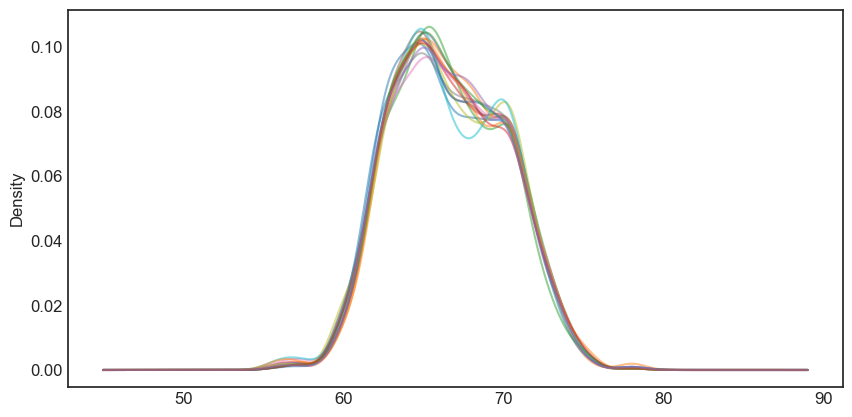

In [44]:
# Random sample of 15 imputed columns
mult_imp.sample(15, axis=1).plot(kind='kde', alpha=0.5, legend=False);

Let's look at the distribution of means across the imputed columns.

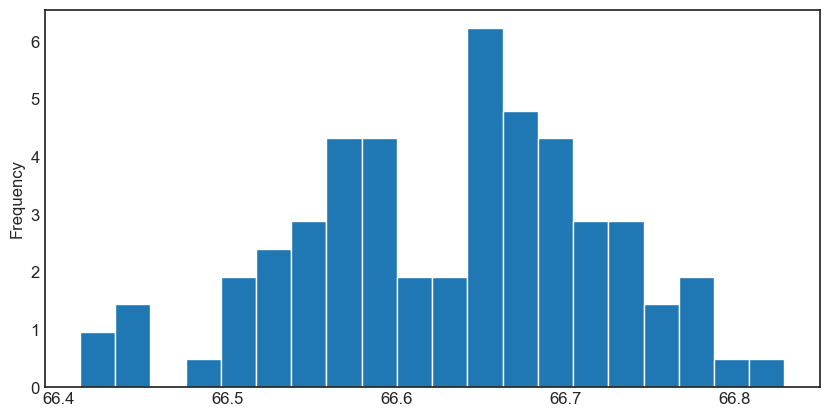

In [45]:
mult_imp.mean().plot(kind='hist', bins=20, ec='w', density=True);

## Summary

### Summary of imputation techniques

* Listwise deletion.
* Mean imputation.
* Group-wise (conditional) mean imputation.
* Probabilistic imputation.
* Multiple imputation.

### Summary: listwise deletion

* Procedure: `.dropna()`.
* If data are MCAR, listwise deletion doesn't change statistics of the data.

### Summary: mean imputation 

* Procedure: `.fillna(df[col].mean())`.
* If data are MCAR, the resulting mean is an unbiased estimate of the true mean, but the variance is too low.
* Analogue for categorical data: imputation with the mode.

### Summary: conditional mean imputation

* Procedure: for a column `c1`, conditional on a second column `c2`:
```
means = df.groupby('c2').mean().to_dict()
imputed = df['c1'].apply(lambda x: means[x] if pd.isna(x) else x)
```
* If data MAR, the resulting mean is an unbiased estimate of the true mean, but the variance is too low.
* This increases correlations between the columns.
* If the column with missing values were dependent on *more than one* column, we can use linear regression to predict the missing value.
    - Will see this again in a few weeks.

### Summary: probabilistic imputation

* Procedure: draw from the distribution of **observed data** to fill in missing values.
* If data are MCAR, the resulting mean and variance are unbiased estimates of the true mean and variance.
* Extending to the MAR case: draw from **conditional empirical distributions**.
    - If data are conditional on a single categorical column `c2`, apply the MCAR procedure to the groups of `df.groupby(c2)`.

### Summary: multiple imputation

* Procedure:
    - Apply probabilistic imputation multiple times, resulting in $N$ imputed datasets.
    - Compute statistics separately on the $N$ imputed datasets (e.g. compute mean or correlation coefficient).
    - Plot the distribution of these statistics and create confidence intervals.
* If a column is missing conditional on multiple columns, your "multiple imputations" should include probabilistic imputations for each!

## Next time in DSC 80...

- Getting data from the internet.